# Задание 4

**Дана выборка абонентов и показателей по ним (ежемесячные начисления, трафик, тип устройства).**  
  
**Необходимо подготовить выборку к анализу (выделить или исключить нехарактерные значения) и сделать сегментацию, выделив 3-5 характерных сегментов на основе профиля абонента. Обосновать выбор критериев и сделать выводы.** 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('test_4.csv',delimiter=';',encoding='cp1251')
display(df.head())
display(df.tail())

,subscriber_id,device_category,month_sum_charge_rub,voice_traffic_rub,data_traffic_mb,roaming_traffic_min
0,4277642,SMARTPHONE,11961.99,1004,13976,2
1,4277933,SMARTPHONE,13864.58,1159,3620,23
2,4278138,SMARTPHONE,3905.09,6301,2298,0
3,4281994,SMARTPHONE,12475.65,1846,6296,70
4,4282050,SMARTPHONE,9519.5,6566,2577,2


,subscriber_id,device_category,month_sum_charge_rub,voice_traffic_rub,data_traffic_mb,roaming_traffic_min
14631,495162131,DATA CARD,44593,0,0,0
14632,495164487,DATA CARD,44593,0,0,0
14633,495454612,DATA CARD,14.43,0,1,0
14634,498468449,DATA CARD,-,0,0,0
14635,498469004,DATA CARD,-,0,0,0


В данных есть прочерки, их необходимо удалить.  

Проведем исследовательский анализ данных (EDA).  
Изучим датасет: есть ли в нем отсутствующие признаки, дубликаты, отклонения, которые необходимо удалить, какие есть типы данных и заменим их при необходимости.  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14636 entries, 0 to 14635
Data columns (total 6 columns):
subscriber_id           14636 non-null int64
device_category         14589 non-null object
month_sum_charge_rub    14636 non-null object
voice_traffic_rub       14636 non-null int64
data_traffic_mb         14636 non-null int64
roaming_traffic_min     14636 non-null int64
dtypes: int64(4), object(2)
memory usage: 686.2+ KB


In [4]:
df.describe()

,subscriber_id,voice_traffic_rub,data_traffic_mb,roaming_traffic_min
count,1.463600e+04,1.463600e+04,1.463600e+04,14636.000000
mean,2.633416e+08,2.241517e+03,2.353134e+04,93.169650
std,1.495653e+08,9.767642e+04,4.820615e+04,308.743696
min,4.277642e+06,-5.410000e+02,-5.193700e+04,-1.000000
25%,1.426874e+08,4.000000e+00,4.737500e+02,0.000000
50%,1.513190e+08,5.800000e+01,3.052500e+03,0.000000
75%,4.148627e+08,9.800000e+02,4.371575e+04,0.000000
max,4.984690e+08,8.335668e+06,1.772188e+06,6783.000000


В данных есть аномально большие и отрицательные значения.   

Найдем и удалим дубликаты.

In [5]:
print('Изначальное кол-во дубликатов', df.duplicated().sum())
df = df.drop_duplicates()
print('Кол-во дубликатов после удаления', df.duplicated().sum())

Изначальное кол-во дубликатов 26
Кол-во дубликатов после удаления 0


Заменим прочерки в колонке "Сумма начислений в месяц, руб" на 0, чтобы можно было работать с цифрами.

In [6]:
df['month_sum_charge_rub'] = df['month_sum_charge_rub'].str.replace('-','0')
display(df.tail())

,subscriber_id,device_category,month_sum_charge_rub,voice_traffic_rub,data_traffic_mb,roaming_traffic_min
14631,495162131,DATA CARD,44593,0,0,0
14632,495164487,DATA CARD,44593,0,0,0
14633,495454612,DATA CARD,14.43,0,1,0
14634,498468449,DATA CARD,0,0,0,0
14635,498469004,DATA CARD,0,0,0,0


Заменим типы данных:  
- в столбце "Сумма начислений в месяц, руб" на числа с плавающей точкой,  
- в столбцах "Трафик голосовой, мин" и "Трафик передачи данных, Мб" на целые числа  

In [7]:
df['month_sum_charge_rub'] = df['month_sum_charge_rub'].astype('float')
df['voice_traffic_rub'] = df['voice_traffic_rub'].astype('int')
df['data_traffic_mb'] = df['data_traffic_mb'].astype('int')
display(df.head())

,subscriber_id,device_category,month_sum_charge_rub,voice_traffic_rub,data_traffic_mb,roaming_traffic_min
0,4277642,SMARTPHONE,11961.99,1004,13976,2
1,4277933,SMARTPHONE,13864.58,1159,3620,23
2,4278138,SMARTPHONE,3905.09,6301,2298,0
3,4281994,SMARTPHONE,12475.65,1846,6296,70
4,4282050,SMARTPHONE,9519.50,6566,2577,2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14610 entries, 0 to 14635
Data columns (total 6 columns):
subscriber_id           14610 non-null int64
device_category         14563 non-null object
month_sum_charge_rub    14610 non-null float64
voice_traffic_rub       14610 non-null int64
data_traffic_mb         14610 non-null int64
roaming_traffic_min     14610 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 799.0+ KB


Найдем отклонения в данных - посчитаем перцентили и отбросим аномально большие и отрицательные значения.

In [9]:
print(np.percentile(df['month_sum_charge_rub'], [95, 99]))

print(np.percentile(df['voice_traffic_rub'], [95, 99]))

print(np.percentile(df['roaming_traffic_min'], [95, 99]))

print(np.percentile(df['data_traffic_mb'], [95, 99]))


[25360.7255 44530.82  ]
[6330.   8941.82]
[ 675.   1226.64]
[ 94926.55 165923.13]


Не более 5% абонентов имели сумму начислений в месяц более 25360.7255 руб.  
Не более 1% абонентов имели сумму начислений в месяц более 44530.82 руб. 

Не более чем у 5% абонентов голосовой трафик составил более 6330 минут.  
Не более чем у 1% абонентов голосовой трафик составил более 8941.82 минут. 
  
Не более чем у 5% абонентов трафик в роуминге составил более 675 минут.  
Не более чем у 1% абонентов трафик в роуминге составил более 1226.64 минут.  
  
Не более чем у 5% абонентов трафик передачи данных составил более 94926.55 Мб.  
Не более чем у 1% абонентов трафик передачи данных составил более 165923.13 Мб. 
 

**Удалим не более 1% аномально высоких значений, чтобы не потерять слишком много данных, а так же отрицательные значения.**

In [10]:
df = df.drop(df[df.month_sum_charge_rub > 44530.82].index)
df = df.drop(df[0 > df.month_sum_charge_rub].index)

df = df.drop(df[df.voice_traffic_rub > 8941.82].index)
df = df.drop(df[0 > df.voice_traffic_rub].index)

df = df.drop(df[df.roaming_traffic_min > 1226.64].index)
df = df.drop(df[0 > df.roaming_traffic_min].index)

df = df.drop(df[df.data_traffic_mb > 165923.13].index)
df = df.drop(df[0 > df.data_traffic_mb].index)

In [11]:
display(df.tail())

,subscriber_id,device_category,month_sum_charge_rub,voice_traffic_rub,data_traffic_mb,roaming_traffic_min
14626,492779356,DATA CARD,0.92,0,1,0
14627,493282794,DATA CARD,32721.00,0,0,0
14633,495454612,DATA CARD,14.43,0,1,0
14634,498468449,DATA CARD,0.00,0,0,0
14635,498469004,DATA CARD,0.00,0,0,0


Разделим типы устройств на 2: PHONE, SMARTPHONE и TABLET определим в категорию "Телефоны и планшеты" и присвоим ей цифру 1, 
а DATA CARD, MODEM, NETWORK DEVICE, ROUTER, USB MODEM - в категорию "Сетевые устройства" и присвоим ей цифру 0

In [12]:
df['device_category'] = df['device_category'].str.replace('SMARTPHONE','1')
df['device_category'] = df['device_category'].str.replace('PHONE','1')
df['device_category'] = df['device_category'].str.replace('TABLET','1')
df['device_category'] = df['device_category'].str.replace('DATA CARD','0')
df['device_category'] = df['device_category'].str.replace('USB MODEM','0')
df['device_category'] = df['device_category'].str.replace('MODEM','0')
df['device_category'] = df['device_category'].str.replace('NETWORK DEVICE','0')
df['device_category'] = df['device_category'].str.replace('ROUTER','0')

Удалим строки, в которых не указан тип устройства, потому что с ними данные будут менее репрезентативны

In [13]:
df.dropna(inplace=True)
#display(df)

После замены значений в столбце с типами устройств заменим и тип данных на целые числа.  
Всего удалили 638 строк - почти 5% данных.

In [14]:
df['device_category'] = df['device_category'].astype('int')

Стандартизируем данные, столбец с id абонента учитывать не будем

In [15]:
scaler = StandardScaler() 
df_drop = scaler.fit_transform(df.drop(columns = ['subscriber_id']))

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.  
На основании полученного графика предположим, какое количество кластеров можно выделить.

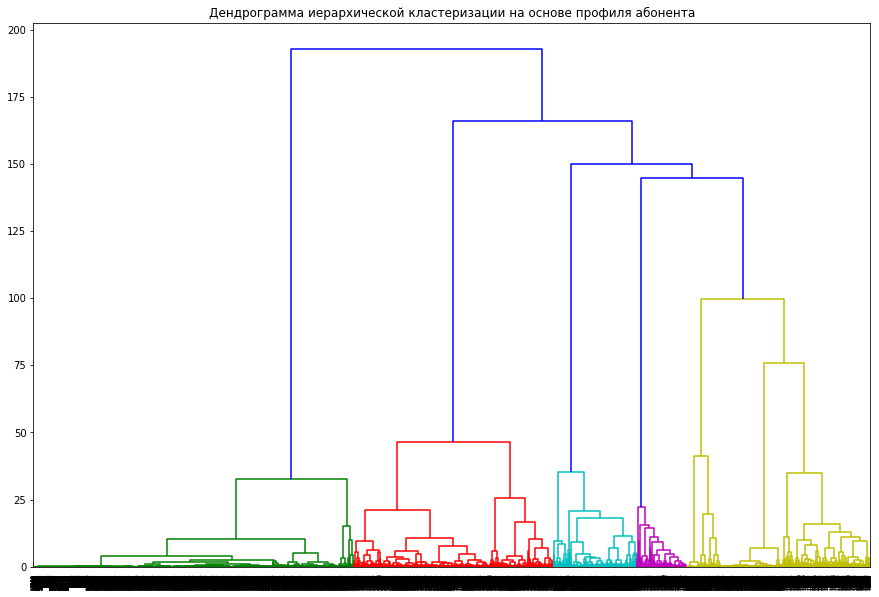

In [16]:
linked = linkage(df_drop, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации на основе профиля абонента')
plt.show()

Видим на дендрограмме 5 кластеров абонентов.

Обучим модель кластеризации на основании алгоритма K-Means

In [17]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(df_drop)
df['cluster_km'] = labels
display(df.head())

,subscriber_id,device_category,month_sum_charge_rub,voice_traffic_rub,data_traffic_mb,roaming_traffic_min,cluster_km
0,4277642,1,11961.99,1004,13976,2,3
1,4277933,1,13864.58,1159,3620,23,3
2,4278138,1,3905.09,6301,2298,0,4
3,4281994,1,12475.65,1846,6296,70,3
4,4282050,1,9519.50,6566,2577,2,4


Уберем столбец с id 

In [18]:
df=df.drop(columns = ['subscriber_id'])

Изучим средние значения признаков для кластеров.  

In [19]:
df_mean_avg = df.groupby('cluster_km').mean()
df_mean_avg = df_mean_avg.transpose()
df_mean_avg.columns = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4']
display(df_mean_avg)

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
device_category,0.151897,0.985298,1.000000,0.739065,0.962963
month_sum_charge_rub,545.569115,1205.553289,3099.773014,21898.543288,2251.323852
voice_traffic_rub,17.980324,611.681753,1250.371097,1038.484666,6817.477778
data_traffic_mb,4136.051944,73224.348804,2446.071169,5952.919055,6025.466667
roaming_traffic_min,0.168739,2.259441,693.116195,28.020613,22.565432


Посчитаем долю каждого кластера от общего обьема

In [20]:
for clast_part in range(0, 5):
    df_int_part = round(df[df['cluster_km'] == clast_part].shape[0]/df.shape[0]*100, 2)
    print('Доля кластера', clast_part, '-', df_int_part, '%')

Доля кластера 0 - 45.39 %
Доля кластера 1 - 24.78 %
Доля кластера 2 - 9.84 %
Доля кластера 3 - 14.21 %
Доля кластера 4 - 5.79 %


**Особенности кластеров:**  
  
**Кластер 0:**  
- самый большой по количеству абонентов  
- абоненты пользуются в основном сетевыми устройствами  
- самая маленькая средняя сумма начислений в месяц  
- самый низкий средний голосовой трафик  
- самый низкий средний трафик в роуминге
  
**Кластер 1:**  
- абоненты пользуются в основном телефонами и планшетами  
- самый большой средний трафик передачи данных - в 12 раз больше, чем у следующего по трафику передачи данных кластеру
  
**Кластер 2:**  
- абоненты пользуются только телефонами и планшетами    
- самый маленький средний трафик передачи данных  
- самый большой средний трафик в роуминге - почти в 25 раз больше, чем у следующего по трафику в роуминге данных кластеру
   
**Кластер 3:** 
- абоненты пользуются и телефонами и планшетами, и сетевыми устройствами, большая часть устройств приходится на телефоны и планшеты  
- самая большая средняя сумма начислений в месяц - в 7 раз больше, чем у следующего по сумме начислений кластеру
  
**Кластер 4:**  
- самый маленький по количеству абонентов
- абоненты пользуются в основном телефонами и планшетами  
- самый высокий средний голосовой трафик - в 5 раз больше, чем у следующего по голосовому трафику кластеру 
  
**Примечательно, что самый большой по количеству абонентов кластер отличается самой маленькой средней суммой начислений в месяц, самым низким средним голосовом трафиком и самым низким средним трафиком в роуминге. Необходимо изучить причины для дальнейшего сокращения этого кластера.**  
  
**Средние максимальные значения показателей распределены по одному среди остальных кластеров.**